# Pool Elo

In [38]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv
from datetime import datetime

In [39]:
data = pd.read_csv('predatorCLP.csv')

In [40]:
players = pd.concat([data.WinnerName, data.LoserName] )

In [41]:
players.value_counts()

Albin Ouschan        52
Mieszko Fortunski    40
Niels Feijen         36
Billy Thorpe         33
Marc Bijsterbosch    27
Kelly Fisher         26
David Alcaide        22
Eklent Kaci          22
Naoyuki Oi           21
Chris Melling        15
Alex Kazakis         15
Roberto Gomez        14
Casper Matikainen    12
Ralf Souquet         12
Kristina Tkach       12
Denis Grabe           7
Jasmin Ouschan        6
Darren Appleton       6
Chris Robinson        6
dtype: int64

In [65]:
# How many players
nplayers = len(players.value_counts())
nplayers

19

<AxesSubplot:>

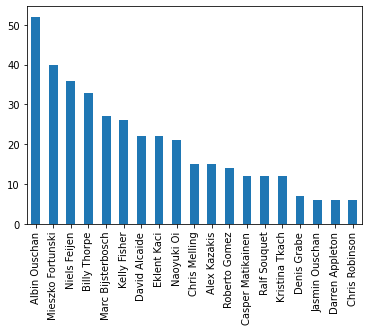

In [43]:
# Plot barplot
players.value_counts().plot(kind='bar')

<AxesSubplot:>

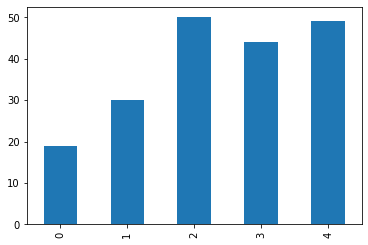

In [50]:
# Visualize Loser Racks
data.LoserRacks.value_counts().loc[range(0,5,1)].plot(kind='bar')

In [45]:
# Validate Even games per table 
data.Table.value_counts()

2    96
1    96
Name: Table, dtype: int64

In [46]:
# Validate Games per group 
data.Group.value_counts()

8    24
7    24
6    24
5    24
4    24
3    24
2    24
1    24
Name: Group, dtype: int64

In [47]:
# Validate 16 Semi Finals
data.isSemi.value_counts()

0    176
1     16
Name: isSemi, dtype: int64

In [48]:
# Validate 8 Finals
data.isFinal.value_counts()

0    184
1      8
Name: isFinal, dtype: int64

In [150]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [151]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

In [182]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [183]:
ratings = run_tournament()

In [184]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Albin Ouschan,1787.939127
Eklent Kaci,1679.107469
David Alcaide,1649.092329
Naoyuki Oi,1641.631940
Chris Melling,1631.589333
Niels Feijen,1578.185503
Marc Bijsterbosch,1572.369034
Denis Grabe,1504.205203
Alex Kazakis,1470.679688
Jasmin Ouschan,1439.981357


In [176]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [177]:
ratingsPrelims = run_tournament(data=prelims)

In [178]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


,ratings
David Alcaide,1705.970310
Niels Feijen,1689.670905
Eklent Kaci,1654.045591
Albin Ouschan,1648.862917
Chris Melling,1641.300990
Naoyuki Oi,1620.890778
Marc Bijsterbosch,1579.173243
Denis Grabe,1504.205203
Alex Kazakis,1470.679688
Jasmin Ouschan,1439.981357


# Accustats

In [1295]:
accustats = pd.read_csv("data/accustats.csv")

In [1296]:
players = pd.concat([accustats.playerA, accustats.playerB] )
players.value_counts()

Shane Van Boening    53
Dennis Orcollo       30
Jayson Shaw          27
Alex Pagulayan       26
Mika Immonen         21
                     ..
Richie Orem           1
Tony Robles           1
Mario He              1
Ivica Putnik          1
Hsieh Chia-Chen       1
Length: 158, dtype: int64

In [1297]:
# How many players
nplayers = len(players.value_counts())
nplayers

158

In [1298]:
# accustats['Date'] = pd.to_datetime(accustats.matchTime)

accustats = accustats.sort_values(by = "matchIndex")

In [1299]:
accustats = accustats.rename(columns = {'matchTime':'date', 
                                       "Competition": 'competition'})
accustats = accustats.drop(columns = ['round'])
accustats.date = pd.to_datetime(accustats['date'])
accustats.head()

,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
341,1,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
342,2,329B-02,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
343,3,329B-03,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
344,4,329B-04,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
345,5,329B-05,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball


In [1300]:

def run_tournament2(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["playerA"]
        loser = row["playerB"]
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [1301]:
accustats_rankings = run_tournament2(data = accustats)

In [1302]:
accustats_rankings.sort_values(by='ratings', ascending = False) 

,ratings
Jayson Shaw,1815.690859
Niels Feijen,1760.334889
Jung Lin Chang,1716.778104
Ralf Souquet,1707.004136
Ronnie Alcano,1675.702555
...,...
Stevie Moore,1353.922497
Ronnie Alcano,1350.969949
Donnie Mills,1341.556310
Ruslan Chinakhov,1317.414697


# Eurotour

In [1303]:
eurotour = pd.read_csv("data/EuroTourTreviso2020.csv")

In [1304]:
import regex as re

def clean_names(df, column):
    result = []
    for idx, row in df.iterrows(): 
        names = re.split('[\\s]+', row[column])
        lastname = ""
        firstname = ""
        for name in names: 
            if name.isupper():
                lastname += str.title(name)
            elif name == "Jr.":
                pass
            else: 
                firstname += str.title(name) + " "
        fullname = firstname + lastname
        result.append(fullname)
    return(result)


In [1305]:
eurotour.playerA = clean_names(eurotour, "playerA")
eurotour.playerB = clean_names(eurotour, "playerB")
eurotour = eurotour.rename(columns={"matchTime":'date'})
eurotour = eurotour.drop(columns = ['round'])
eurotour['competition'] = "2020 EuroTour Treviso"
eurotour.date = pd.to_datetime(eurotour['date'])

In [1306]:
fulldf1 = pd.merge(accustats, eurotour, on=["playerA", "playerB", "playerARacks",
                                           "playerBRacks", 'date', 'matchNumber',
                                          "competition"], 
                  how='outer')

In [1307]:

fulldf1 = fulldf1.sort_values(by= ['date', 'matchIndex']).reset_index(drop=True)

In [1308]:
fulldf1

,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,1.0,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,2.0,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,3.0,329B-03,2007-10-14 00:00:00,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,4.0,329B-04,2007-10-14 00:00:00,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,5.0,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...
771,NaN,SE27,2020-02-22 12:00:00,Eklent Kaci,9,Maximillian Lechner,0,2020 EuroTour Treviso
772,NaN,SE28,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
773,NaN,SE29,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
774,NaN,SE30,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


# WPA W9-Ball 2019

In [1309]:
wpa = pd.read_csv("data/WPAW9Ball.csv")
wpa = wpa.rename(columns = {"WinnerName":"playerA", 
                      "LoserName": "playerB", 
                      "WinnerRacks":"playerARacks", 
                      "LoserRacks":"playerBRacks",
                      "Round":"round", 
                      "Date":'date',
                      "GameID": 'matchIndex'})
wpa['competition'] = "WPA World 9-Ball Championship"
wpa = wpa.drop(columns = 'round')
wpa.date = pd.to_datetime(wpa['date'])

In [1310]:
wpa

,matchIndex,playerA,playerB,playerARacks,playerBRacks,date,competition
0,1,Casper Matikainen,Joshua Filler,11,7,2019-12-13,WPA World 9-Ball Championship
1,2,Yip Kin Ling,John Morra,11,5,2019-12-13,WPA World 9-Ball Championship
2,3,Albin Ouschan,Lin Ta Li,11,5,2019-12-13,WPA World 9-Ball Championship
3,4,Denis Grabe,Marc Bijsterbosch,11,8,2019-12-13,WPA World 9-Ball Championship
4,5,Jung-Lin Chang,Dang Jinhu,11,9,2019-12-13,WPA World 9-Ball Championship
...,...,...,...,...,...,...,...
58,59,Chung Ko Ping,Do The Kien,11,6,2019-12-16,WPA World 9-Ball Championship
59,60,Fedor Gorst,Pin Yi Ko,11,6,2019-12-16,WPA World 9-Ball Championship
60,61,Jung-Lin Chang,Liu Haitao,11,6,2019-12-17,WPA World 9-Ball Championship
61,62,Fedor Gorst,Chung Ko Ping,11,7,2019-12-17,WPA World 9-Ball Championship


In [1311]:
fulldf2 = pd.merge(fulldf1, wpa, on=["playerA", "playerB", "playerARacks",
                                   "playerBRacks", 'date', 'matchIndex',
                                          "competition"], 
                  how='outer')

In [1312]:
fulldf2 = fulldf2.sort_values(by= ['date', 'matchIndex']).reset_index(drop=True)

In [1313]:
fulldf2

,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,1.0,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,2.0,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,3.0,329B-03,2007-10-14 00:00:00,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,4.0,329B-04,2007-10-14 00:00:00,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,5.0,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...
834,NaN,SE27,2020-02-22 12:00:00,Eklent Kaci,9,Maximillian Lechner,0,2020 EuroTour Treviso
835,NaN,SE28,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
836,NaN,SE29,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
837,NaN,SE30,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


# US Open

In [1314]:


usopen = pd.read_csv("data/usopen2019.csv")
usopen = usopen.rename(columns = {"winner":"playerA", 
                      "loser": "playerB", 
                      "winnerScore":"playerARacks", 
                      "loserScore":"playerBRacks",
                      "Round":"round", 
                      "matchTime":'date',
                      "matchNum": 'matchIndex', 
                      'tournament':'competition'})
usopen = usopen.drop(columns = ["winnerNationality", "winnerRunouts", 
                                "loserNationality", "loserRunouts","Unnamed: 0" ])
usopen.date = pd.to_datetime(usopen['date'])

In [1315]:
fulldf2.dtypes

matchIndex             float64
matchNumber             object
date            datetime64[ns]
playerA                 object
playerARacks             int64
playerB                 object
playerBRacks             int64
competition             object
dtype: object

In [1316]:



usopen.dtypes

playerA                 object
playerARacks             int64
playerB                 object
playerBRacks             int64
matchIndex               int64
date            datetime64[ns]
competition             object
dtype: object

In [1317]:
fulldf3 = pd.merge(fulldf2, usopen, on=["playerA", "playerB", "playerARacks",
                                           "playerBRacks", 'date', 'matchIndex',
                                          "competition"], 
                  how='outer')

fulldf3 = fulldf3.sort_values(by= ['date', 'matchIndex']).reset_index(drop=True)


In [1318]:
fulldf3

,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition
0,1.0,329B-01,2007-10-14 00:00:00,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball
1,2.0,329B-02,2007-10-14 00:00:00,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball
2,3.0,329B-03,2007-10-14 00:00:00,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball
3,4.0,329B-04,2007-10-14 00:00:00,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball
4,5.0,329B-05,2007-10-14 00:00:00,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball
...,...,...,...,...,...,...,...,...
1329,NaN,SE27,2020-02-22 12:00:00,Eklent Kaci,9,Maximillian Lechner,0,2020 EuroTour Treviso
1330,NaN,SE28,2020-02-22 12:00:00,Mickey Krause,4,Mateusz Sniegocki,9,2020 EuroTour Treviso
1331,NaN,SE29,2020-02-22 14:00:00,Fedor Gorst,3,Jayson Shaw,9,2020 EuroTour Treviso
1332,NaN,SE30,2020-02-22 15:30:00,Eklent Kaci,9,Mateusz Sniegocki,6,2020 EuroTour Treviso


# Turning Stone Classic 2017

In [1319]:
tstone = pd.read_csv("data/turningstone2017.csv")
tstone = tstone.rename(columns = {"winner":"playerA", 
                      "loser": "playerB", 
                      "winnerScore":"playerARacks", 
                      "loserScore":"playerBRacks",
                      "Round":"round", 
                      "matchTime":'date',
                      "matchNum": 'matchIndex', 
                      'tournament':'competition'})
tstone = tstone.drop(columns = ["winnerNationality", "winnerRunouts", 
                                "loserNationality", "loserRunouts","Unnamed: 0" ])
tstone.date = pd.to_datetime(tstone['date'])
tstone['competition'] = "2017 Turning Stone Classic XXVII 9-Ball Open"

In [1320]:
tstone.head()

,playerA,playerARacks,playerB,playerBRacks,matchIndex,date,competition
0,Mike Yednak,9,Roger Miller,5,1,2017-01-06 18:23:00,2017 Turning Stone Classic XXVII 9-Ball Open
1,Johnny Archer,9,Jamie Addessi,2,2,2017-01-06 18:23:00,2017 Turning Stone Classic XXVII 9-Ball Open
2,Jonathan Smith,9,Brian Trinci,5,3,2017-01-06 18:23:00,2017 Turning Stone Classic XXVII 9-Ball Open
3,Oscar Dominguez,9,Mike Giurleo,3,4,2017-01-06 18:23:00,2017 Turning Stone Classic XXVII 9-Ball Open
4,Chris Braiman,9,Robert Ferry,7,5,2017-01-06 18:23:00,2017 Turning Stone Classic XXVII 9-Ball Open


In [1321]:
fulldf4 = pd.merge(fulldf3, tstone, on=["playerA", "playerB", "playerARacks",
                                           "playerBRacks", 'date', 'matchIndex',
                                          "competition"], 
                  how='outer')

fulldf4 = fulldf4.sort_values(by= ['date', 'matchIndex']).reset_index(drop=True)


In [1322]:
fulldf4['playerA'] = fulldf4['playerA'].str.strip()
fulldf4['playerB'] = fulldf4['playerB'].str.strip()

In [1323]:
fulldf4['playerA'][fulldf4['playerA'] == "Francisco SanchezRuiz"] = "Francisco Sanchez Ruiz"
fulldf4['playerB'][fulldf4['playerB'] == "Francisco SanchezRuiz"] = "Francisco Sanchez Ruiz"

/Users/sethbilliau/python-virtual-environments/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sethbilliau/python-virtual-environments/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# WPA 2018

In [1324]:
wpa2 = pd.read_csv('data/WPA2015_18.csv')
wpa2.date = pd.to_datetime(wpa2018['date'])

In [1325]:
fulldf5 = pd.merge(fulldf4, wpa2, on=["playerA", "playerB", "playerARacks",
                                   "playerBRacks", 'date', 'matchIndex',
                                          "competition"], 
                  how='outer')

fulldf5 = fulldf5.sort_values(by= ['date', 'matchIndex']).reset_index(drop=True)

In [1326]:
fulldf5

,matchIndex,matchNumber,date,playerA,playerARacks,playerB,playerBRacks,competition,Unnamed: 0
0,1.0,329B-01,2007-10-14,Shane Van Boening,11,Ronnie Alcano,4,2007 US Open 9-Ball,NaN
1,2.0,329B-02,2007-10-14,Ernesto Dominguez,11,Frankie Hernandez,5,2007 US Open 9-Ball,NaN
2,3.0,329B-03,2007-10-14,Tony Robles,11,Rafael Martinez,5,2007 US Open 9-Ball,NaN
3,4.0,329B-04,2007-10-14,Louis Ulrich,11,Alex Pagulayan,7,2007 US Open 9-Ball,NaN
4,5.0,329B-05,2007-10-14,Francisco Bustamante,11,Richie Orem,4,2007 US Open 9-Ball,NaN
...,...,...,...,...,...,...,...,...,...
2460,221.0,NaN,NaT,Joshua Filler,11,Alexander Kazakis,10,2018 WPA World 9-Ball Championship,878.0
2461,222.0,NaN,NaT,Shane Van Boening,11,Cheng Yu-hsuan,9,2016 WPA World 9-Ball Championship,444.0
2462,222.0,NaN,NaT,Carlo Biado,11,Shane Van Boening,6,2018 WPA World 9-Ball Championship,879.0
2463,223.0,NaN,NaT,Albin Ouschan,13,Shane Van Boening,6,2016 WPA World 9-Ball Championship,445.0


In [1327]:
fulldf = fulldf5

# Elo 

In [1328]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50



players = pd.concat([fulldf.playerA, fulldf.playerB] )
print(players.value_counts().index.unique())
# How many players
nplayers = len(players.value_counts())
nplayers

Index(['Shane Van Boening', 'Jayson Shaw', 'Alex Pagulayan', 'Albin Ouschan',
       'Darren Appleton', 'Joshua Filler', 'Thorsten Hohmann', 'Niels Feijen',
       'Dennis Orcollo', 'Carlo Biado',
       ...
       'Le Quang Trun', 'Yukio Akagariyama', 'Shane McMinn', 'RJ Carmona',
       'Xue Zhenqi', 'Hsieh Chia-Chen', 'Ricky Yang', 'Khaled Al Otaibi',
       'Maxim Dudanets', 'Konstantin Stepanov'],
      dtype='object', length=867)


867

In [1329]:



def run_tournament3(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        if row['playerARacks'] > row['playerBRacks']: 
            winner = row["playerA"]
            loser = row["playerB"]
        else: 
            winner = row['playerB']
            loser = row['playerA']
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [1330]:
ratings = run_tournament3(fulldf)

In [1331]:
ratings
ratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Albin Ouschan,2019.919609
Joshua Filler,2011.611488
Jayson Shaw,2004.156218
Carlo Biado,1992.937012
Fedor Gorst,1935.577924
Shane Van Boening,1931.939808
Wu Kun-lin,1888.698797
Alexander Kazakis,1879.168635
Eklent Kaci,1867.685854
Liu Haitao,1859.954339


In [1332]:
players

0          Shane Van Boening
1          Ernesto Dominguez
2                Tony Robles
3               Louis Ulrich
4       Francisco Bustamante
                ...         
2460       Alexander Kazakis
2461          Cheng Yu-hsuan
2462       Shane Van Boening
2463       Shane Van Boening
2464             Carlo Biado
Length: 4930, dtype: object

In [1333]:
data = pd.read_csv('data/predatorCLP.csv')
playersCLP = pd.concat([data.WinnerName, data.LoserName] )

In [1334]:
ratings.index

Index(['Shane Van Boening', 'Jayson Shaw', 'Alex Pagulayan', 'Albin Ouschan',
       'Darren Appleton', 'Joshua Filler', 'Thorsten Hohmann', 'Niels Feijen',
       'Dennis Orcollo', 'Carlo Biado',
       ...
       'Le Quang Trun', 'Yukio Akagariyama', 'Shane McMinn', 'RJ Carmona',
       'Xue Zhenqi', 'Hsieh Chia-Chen', 'Ricky Yang', 'Khaled Al Otaibi',
       'Maxim Dudanets', 'Konstantin Stepanov'],
      dtype='object', length=867)

In [1335]:
# Get correct players
playersindex = []
names = []
for player in playersCLP.unique():
    if player in ratings.index:
        playersindex.append(np.where(players.value_counts().index == player)[0][0])
        names.append(np.where(ratings.index == player)[0][0])


In [1336]:
# Games in the prior dataset
players.value_counts()[playersindex]
fullPlayerList = list(players.value_counts()[playersindex].index)
fullPlayerList.append("Kristina Tkach")
fullPlayerList.append("Kelly Fisher")

CLPratings = ratings.iloc[np.array(names)]
CLPratings = CLPratings.append([{"ratings": 1500},{"ratings": 1500}], ignore_index = True)

CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )

In [1342]:
CLPratings.sort_values(by = "ratings", ascending = False)

,ratings
Albin Ouschan,2019.919609
Eklent Kaci,1867.685854
Niels Feijen,1708.146201
Naoyuki Oi,1671.502146
Alex Kazakis,1660.986234
Denis Grabe,1660.541487
Casper Matikainen,1653.057988
Chris Melling,1650.580484
Ralf Souquet,1636.702365
David Alcaide,1586.413081


In [1343]:

def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

import math

def get_loglikelihood(newdata, ratings, ELO_WIDTH = ELO_WIDTH):

    loglikelihood = 0
    # Iterate through rows of dataframe 
    for index, row in newdata.iterrows():
        winnerrating = ratings.loc[row["WinnerName"]]
        loserrating = ratings.loc[row["LoserName"]]
        proba = expected(winnerrating, loserrating, ELO_WIDTH)   
            

        loglikelihood += math.log(proba)

        
    return(loglikelihood)

In [1344]:
get_loglikelihood(data, CLPratings)

-146.51677664879495

In [1345]:
data

,GameID,WinnerName,LoserName,LoserRacks,Table,isSemi,isFinal,Group
0,1,Chris Melling,Ralf Souquet,0,1,0,0,1
1,2,Albin Ouschan,Chris Robinson,2,2,0,0,1
2,3,Kelly Fisher,Niels Feijen,4,1,0,0,1
3,4,Eklent Kaci,Albin Ouschan,4,2,0,0,1
4,5,Niels Feijen,Chris Robinson,3,1,0,0,1
...,...,...,...,...,...,...,...,...
187,188,Albin Ouschan,Niels Feijen,4,1,0,0,8
188,189,Naoyuki Oi,David Alcaide,4,2,0,0,8
189,190,Albin Ouschan,Eklent Kaci,2,1,1,0,8
190,191,David Alcaide,Chris Melling,2,2,1,0,8


# Tuning K

In [1346]:
K = np.arange(1, 101, 1)

In [1347]:
log_likelihoods = []
for k in K: 
    # Get ratings 
    allratings = run_tournament3(fulldf, K=k)
    
    # Filter ratings 
    CLPratings = allratings.iloc[np.array(names)]
    CLPratings = CLPratings.append([{"ratings": 1500},{"ratings": 1500}], ignore_index = True)
    CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
    
    log_likelihoods.append(get_loglikelihood(data, CLPratings))

Optimal K is 15


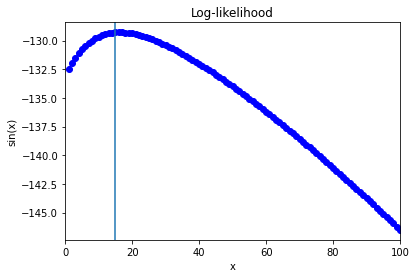

In [1348]:
ax = plt.axes()
ax.plot(K, log_likelihoods, '--bo')
ax.axvline(log_likelihoods.index(max(log_likelihoods)))
ax.set(xlim=(0, 100),
       xlabel='x', ylabel='sin(x)',
       title='Log-likelihood');
print("Optimal K is " + str(log_likelihoods.index(max(log_likelihoods))))

In [1359]:
# Get ratings 
allratings = run_tournament3(fulldf, K=15)
allratings.sort_values(by='ratings', ascending = False)[0:25]


,ratings
Albin Ouschan,2019.919609
Joshua Filler,2011.611488
Jayson Shaw,2004.156218
Carlo Biado,1992.937012
Fedor Gorst,1935.577924
Shane Van Boening,1931.939808
Wu Kun-lin,1888.698797
Alexander Kazakis,1879.168635
Eklent Kaci,1867.685854
Liu Haitao,1859.954339


In [1350]:
# Filter ratings 
CLPratings = allratings.iloc[np.array(names)]
CLPratings = CLPratings.append([{"ratings": 1500},{"ratings": 1500}], ignore_index = True)
CLPratings = CLPratings.set_index(pd.Index(fullPlayerList) )
CLPratings.sort_values(by='ratings', ascending = False)

,ratings
Albin Ouschan,2019.919609
Eklent Kaci,1867.685854
Niels Feijen,1708.146201
Naoyuki Oi,1671.502146
Alex Kazakis,1660.986234
Denis Grabe,1660.541487
Casper Matikainen,1653.057988
Chris Melling,1650.580484
Ralf Souquet,1636.702365
David Alcaide,1586.413081


# Update Posterior Ratings after Predator CLP

In [1351]:

def run_tournament_with_prior_ratings(data, priorratings, ELO_WIDTH = ELO_WIDTH, K=29):
    

    # Initialize Elo Ratings
    elo_ratings = priorratings

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        k=K
#         if row['isSemi'] == True: 
#             k = K*2
#         elif row['isFinal'] == True: 
#             k = K*3
#         else: 
#             k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings.loc[winner][0], elo_ratings.loc[loser][0], k, ELO_WIDTH)
        elo_ratings.loc[winner][0] = new_winner_rating
        elo_ratings.loc[loser][0] = new_loser_rating
    return(elo_ratings)

In [1352]:
posterior_ratings = run_tournament_with_prior_ratings(data, priorratings = CLPratings)

In [1353]:
posterior_ratings.sort_values(by = "ratings", ascending = False)

,ratings
Eklent Kaci,1864.666825
Albin Ouschan,1808.431719
Chris Melling,1718.823379
David Alcaide,1718.225060
Niels Feijen,1712.572485
Naoyuki Oi,1689.549540
Denis Grabe,1667.401347
Alex Kazakis,1649.613565
Ralf Souquet,1575.542445
Casper Matikainen,1570.423520
